FEITO COM O BERT LOCALMENTE COM UMA 4060 TI

# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 393.8 kB/s eta 0:00:33
      --------------------------------------- 0.2/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.5/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 3.9 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 4.6 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 5.3 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 6.0 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 6.5 MB/s eta 0:00:02
     ---------- ----------------------------- 3.2/12.8 MB 7.1 MB/s eta 0:00:02
     ----------- ---------------------------- 3.8/12.8 MB 7.7 MB/s eta 0

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm
import re
import warnings
from sklearn.dummy import DummyClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from sklearn.linear_model import LogisticRegression
import spacy
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import torch
import transformers
from sklearn.model_selection import train_test_split

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [5]:
# isso é para usar progress_apply
tqdm.pandas()

## Carregar Dados

In [6]:
df_reviews = pd.read_csv('imdb_reviews.csv')

In [7]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254.0,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278.0,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278.0,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278.0,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [8]:
df_reviews.describe(include='all')

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
count,47331,47331,47331,47331,47331.000000,47331,47331,47331.000000,47331,47329.000000,4.732900e+04,47331,47331.000000,47331,47331.000000,47331,47331.000000
unique,6648,10,6555,6562,NaN,60,249,NaN,585,NaN,NaN,47240,NaN,2,NaN,2,NaN
top,tt0067445,movie,The Sentinel,The Sentinel,NaN,\N,90,NaN,Drama,NaN,NaN,Loved today's show!!! It was a variety and not...,NaN,neg,NaN,train,NaN
freq,30,36861,60,60,NaN,45052,2442,NaN,3392,NaN,NaN,5,NaN,23715,NaN,23796,NaN
mean,NaN,NaN,NaN,NaN,1989.631235,NaN,NaN,0.001732,NaN,5.998278,2.556292e+04,NaN,5.484608,NaN,0.498954,NaN,6279.697999
std,NaN,NaN,NaN,NaN,19.600364,NaN,NaN,0.041587,NaN,1.494289,8.367004e+04,NaN,3.473109,NaN,0.500004,NaN,3605.702545
min,NaN,NaN,NaN,NaN,1894.000000,NaN,NaN,0.000000,NaN,1.400000,9.000000e+00,NaN,1.000000,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,1982.000000,NaN,NaN,0.000000,NaN,5.100000,8.270000e+02,NaN,2.000000,NaN,0.000000,NaN,3162.000000
50%,NaN,NaN,NaN,NaN,1998.000000,NaN,NaN,0.000000,NaN,6.300000,3.197000e+03,NaN,4.000000,NaN,0.000000,NaN,6299.000000
75%,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,0.000000,NaN,7.100000,1.397400e+04,NaN,9.000000,NaN,1.000000,NaN,9412.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

<Axes: xlabel='pos'>

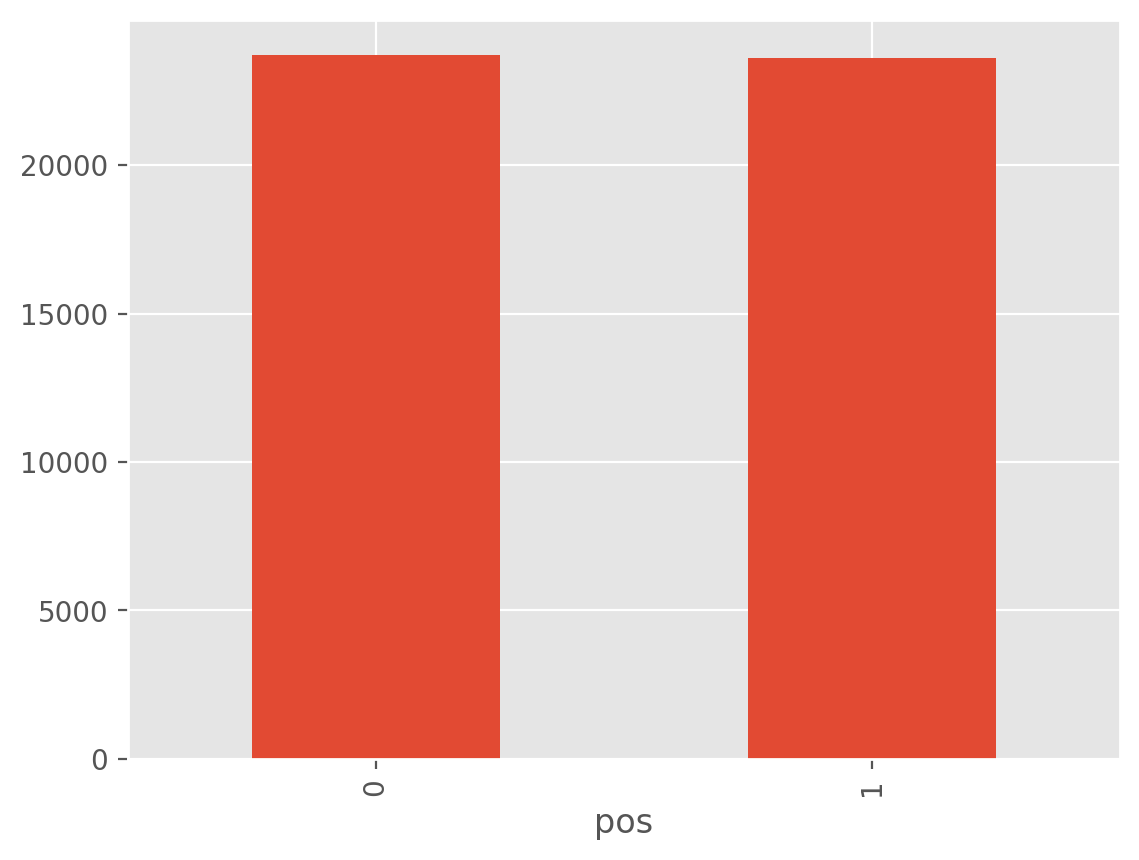

In [9]:
df_reviews.info()

df_reviews['pos'].value_counts().plot(kind='bar')

In [10]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

**O conjunto de dados df_reviews possui 47331 registros e abrange diversas informações sobre reviews, como tipos de títulos, ratings, entre outras. A coluna 'pos', que aparentemente indica uma classificação binária, mostra uma distribuição quase uniforme entre suas categorias, tornando o conjunto balanceado nesse aspecto específico.**

## AED

### Vamos verificar o número de filmes e resenhas ao longo dos anos.

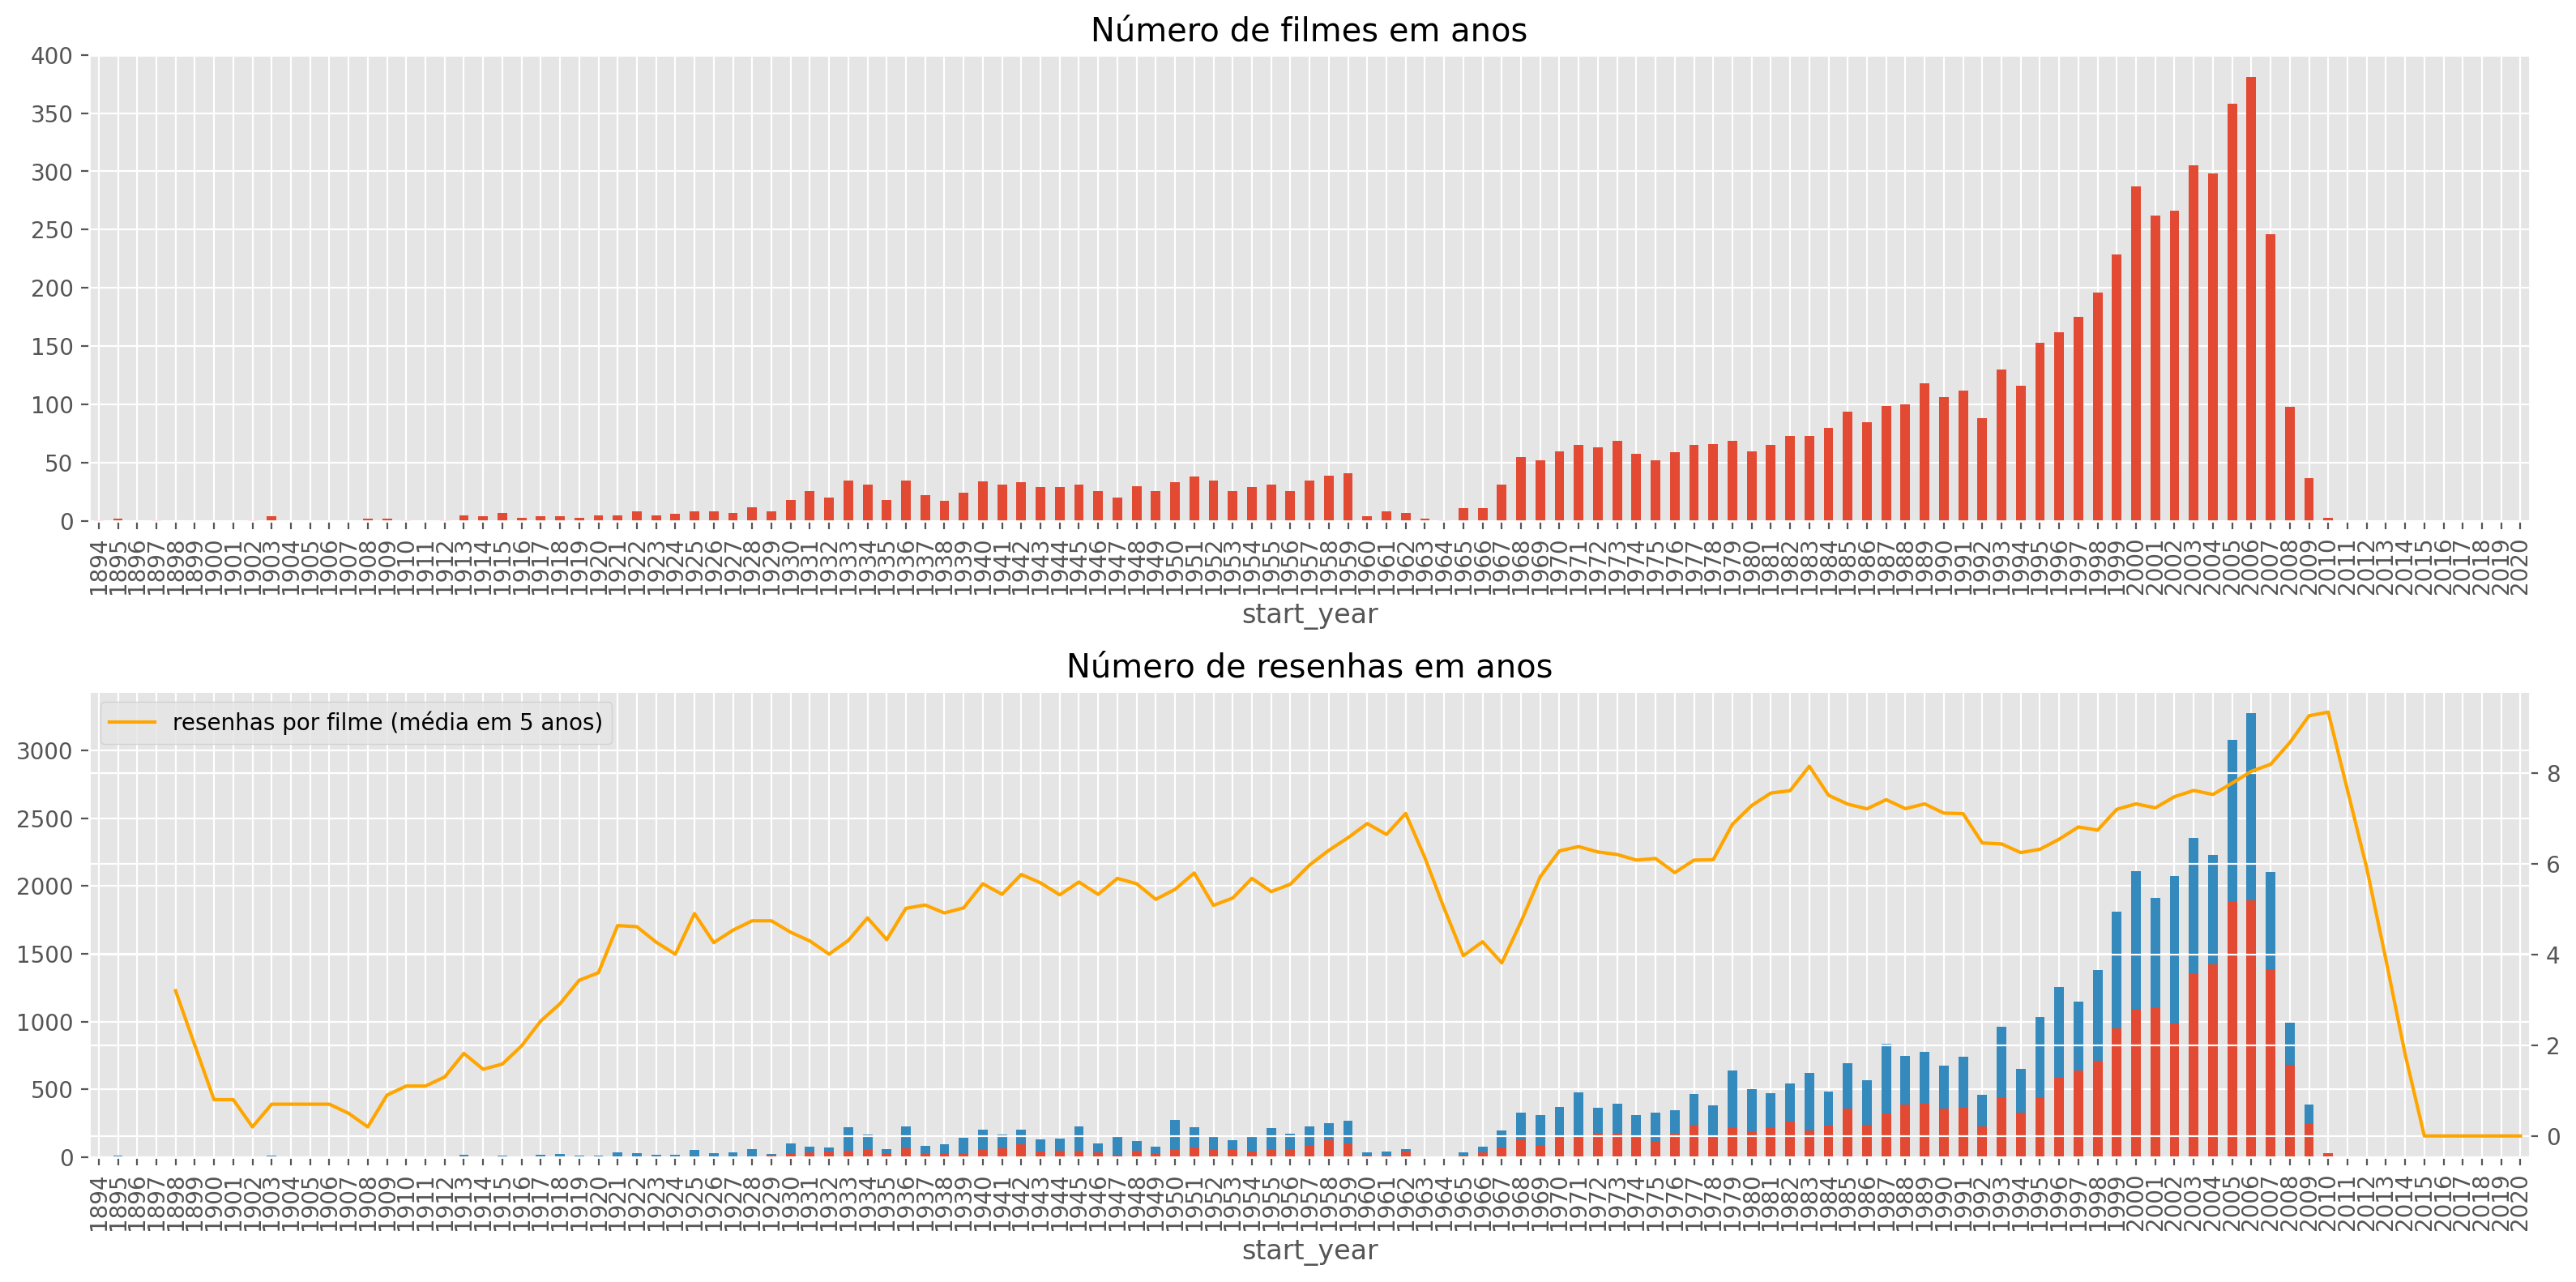

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

**Número de Filmes ao Longo dos Anos (Gráfico superior):** Observa-se um aumento gradual na quantidade de filmes a partir do início do período considerado, culminando em uma elevação expressiva nas últimas décadas. Esse aumento pode indicar um crescimento da indústria cinematográfica ou simplesmente um maior registro de filmes no banco de dados.

**Número de Resenhas ao Longo dos Anos (Gráfico inferior):** A quantidade de resenhas por ano apresenta uma tendência de aumento, especialmente nas últimas décadas, alinhando-se com a observação do gráfico superior. Além disso, é possível notar a linha laranja que representa a média móvel das resenhas por filme (média em 5 anos), mostrando uma tendência geral de crescimento, mas com uma queda abrupta recentemente.

**Conclusão:**

**Houve um crescimento notável na quantidade de filmes e resenhas ao longo dos anos, com um pico notável nas últimas décadas. Esse aumento pode refletir um crescimento na indústria cinematográfica e/ou na popularidade das plataformas de resenhas. Entretanto, a recente queda na média móvel de resenhas por filme pode indicar uma saturação ou mudança no comportamento do público em relação à revisão de filmes.**

### Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

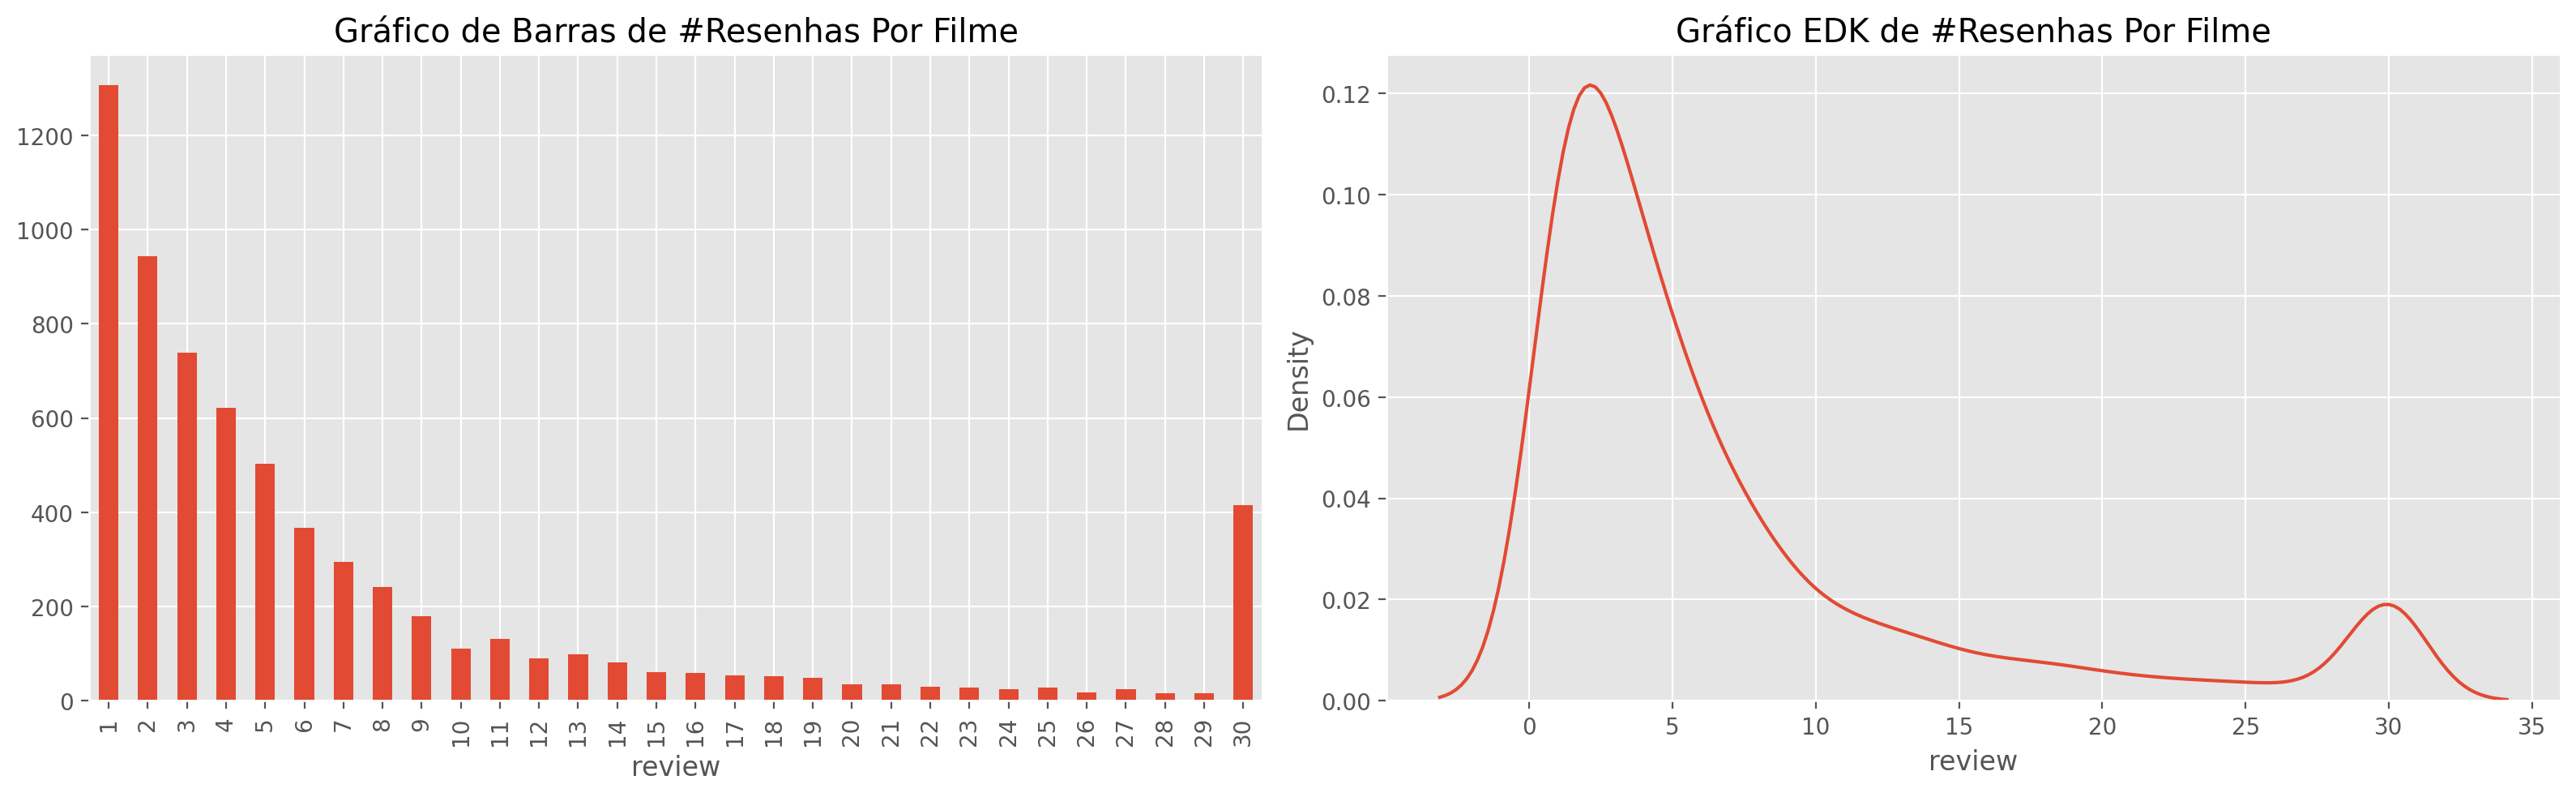

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

**Gráfico de Barras de #Resenhas Por Filme (Gráfico à esquerda):** A maioria dos filmes tem um pequeno número de resenhas, com a contagem decrescendo acentuadamente à medida que o número de resenhas por filme aumenta. Isso indica que muitos filmes têm apenas algumas resenhas, enquanto poucos filmes acumulam um grande número de resenhas.

**Gráfico EDK de #Resenhas Por Filme (Gráfico à direita):** O gráfico de densidade estima a probabilidade de um filme ter um determinado número de resenhas. A forma da distribuição é assimétrica, com um pico acentuado para filmes com um número baixo de resenhas e uma cauda longa, indicando que há poucos filmes com um número muito elevado de resenhas.

**Conclusão:** A maior parte dos filmes tem um número limitado de resenhas, sugerindo que uma grande proporção de filmes não é amplamente revisada ou discutida. No entanto, existe um pequeno conjunto de filmes que recebem um número significativamente maior de resenhas, destacando-se em popularidade ou relevância.

### Graficos de distribuição de classificações 

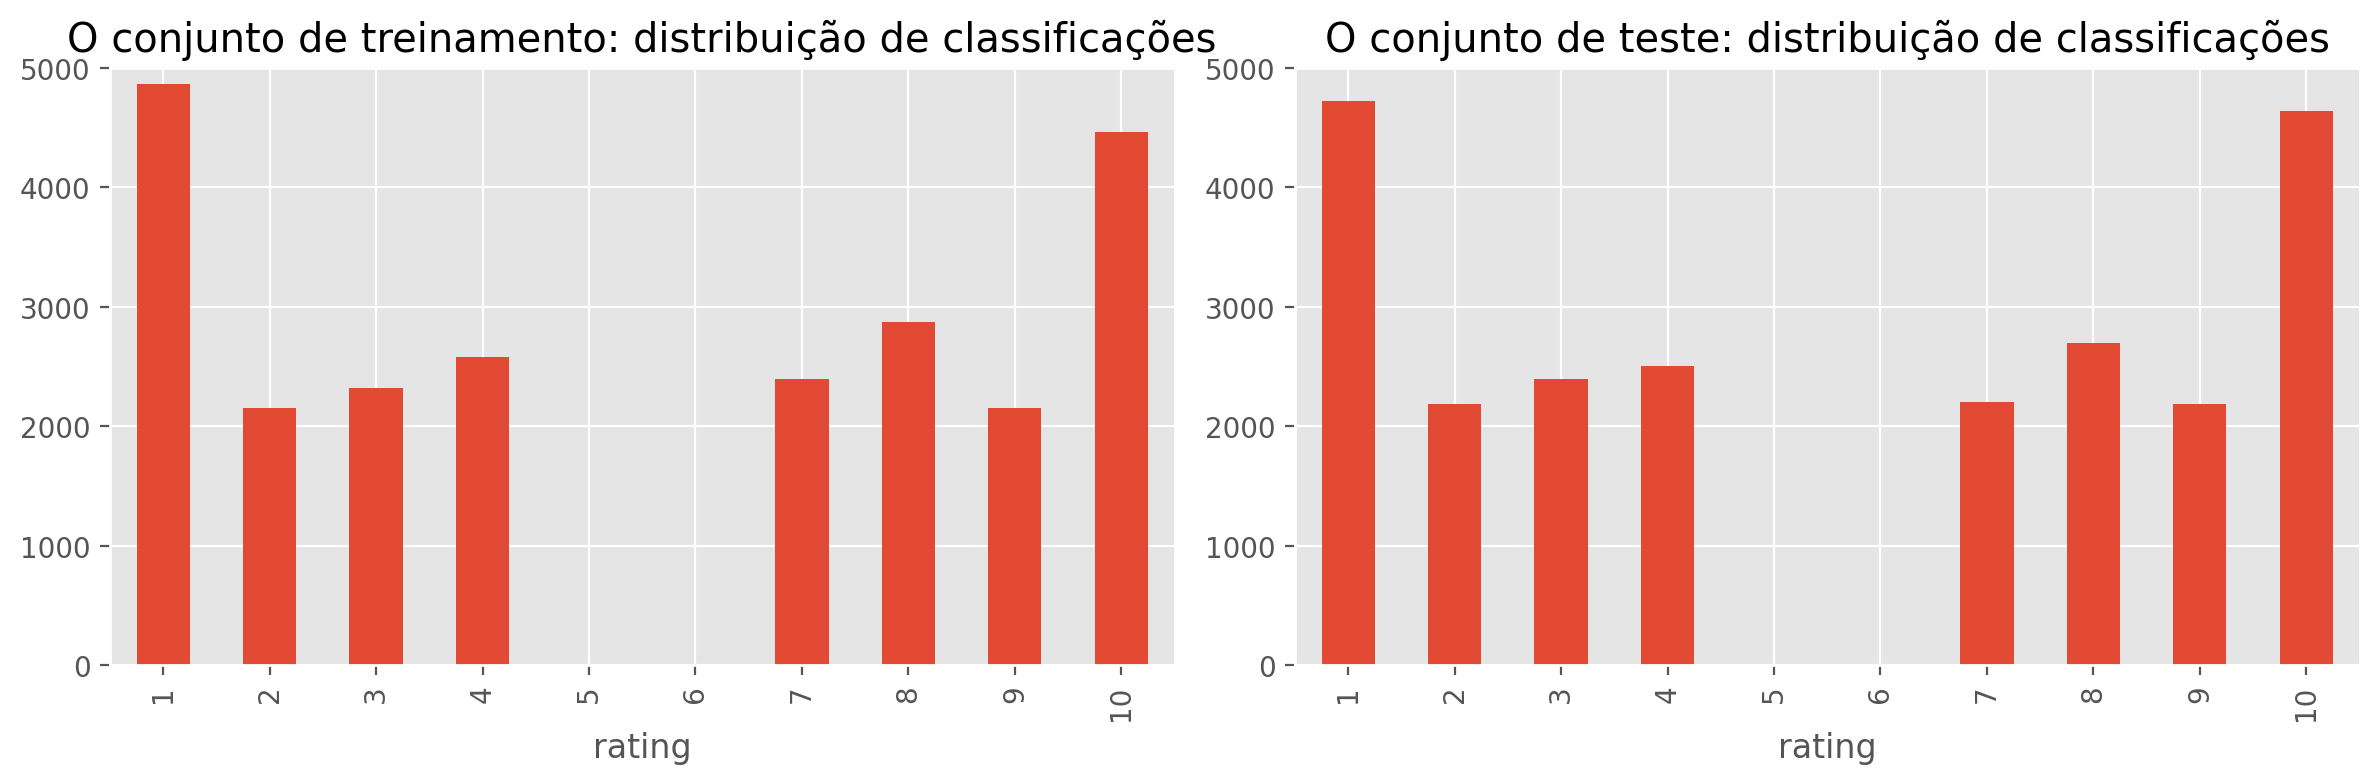

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Os gráficos apresentam a distribuição das classificações (ratings) de resenhas em dois conjuntos de dados: treinamento e teste.

**Conjunto de Treinamento (Gráfico à esquerda):** Há uma prevalência significativa de resenhas com classificação 1, seguida de uma contagem moderada para classificações 3, 4, 6 e 7. As outras classificações têm uma frequência notavelmente menor.

**Conjunto de Teste (Gráfico à direita):** A distribuição das classificações neste conjunto é similar ao conjunto de treinamento, com a classificação 1 também sendo a mais prevalente. As classificações 3, 4, 6 e 7 seguem em frequência, enquanto as demais classificações permanecem com contagens mais baixas.

**Conclusão:** Em ambos os conjuntos, treinamento e teste, há uma tendência notável de ter uma quantidade elevada de resenhas com classificação 1. Isso pode indicar que muitos usuários tendem a dar classificações baixas ou que o conjunto de dados pode ter um viés para resenhas negativas. As demais classificações apresentam uma distribuição mais uniforme, com ligeiras variações. Importante notar que a similaridade nas distribuições entre os conjuntos de treinamento e teste é um bom indicativo, pois sugere que ambos os conjuntos são representativos e comparáveis em termos de classificações de resenhas.

### Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

C:\Users\DANIEL\AppData\Local\Temp\ipykernel_5400\1483671763.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\DANIEL\AppData\Local\Temp\ipykernel_5400\1483671763.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\DANIEL\AppData\Local\Temp\ipykernel_5400\1483671763.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\DANIEL\AppData\Local\Temp\ipykernel_5400\1483671763.py:31: UserWarning: 

Support for a

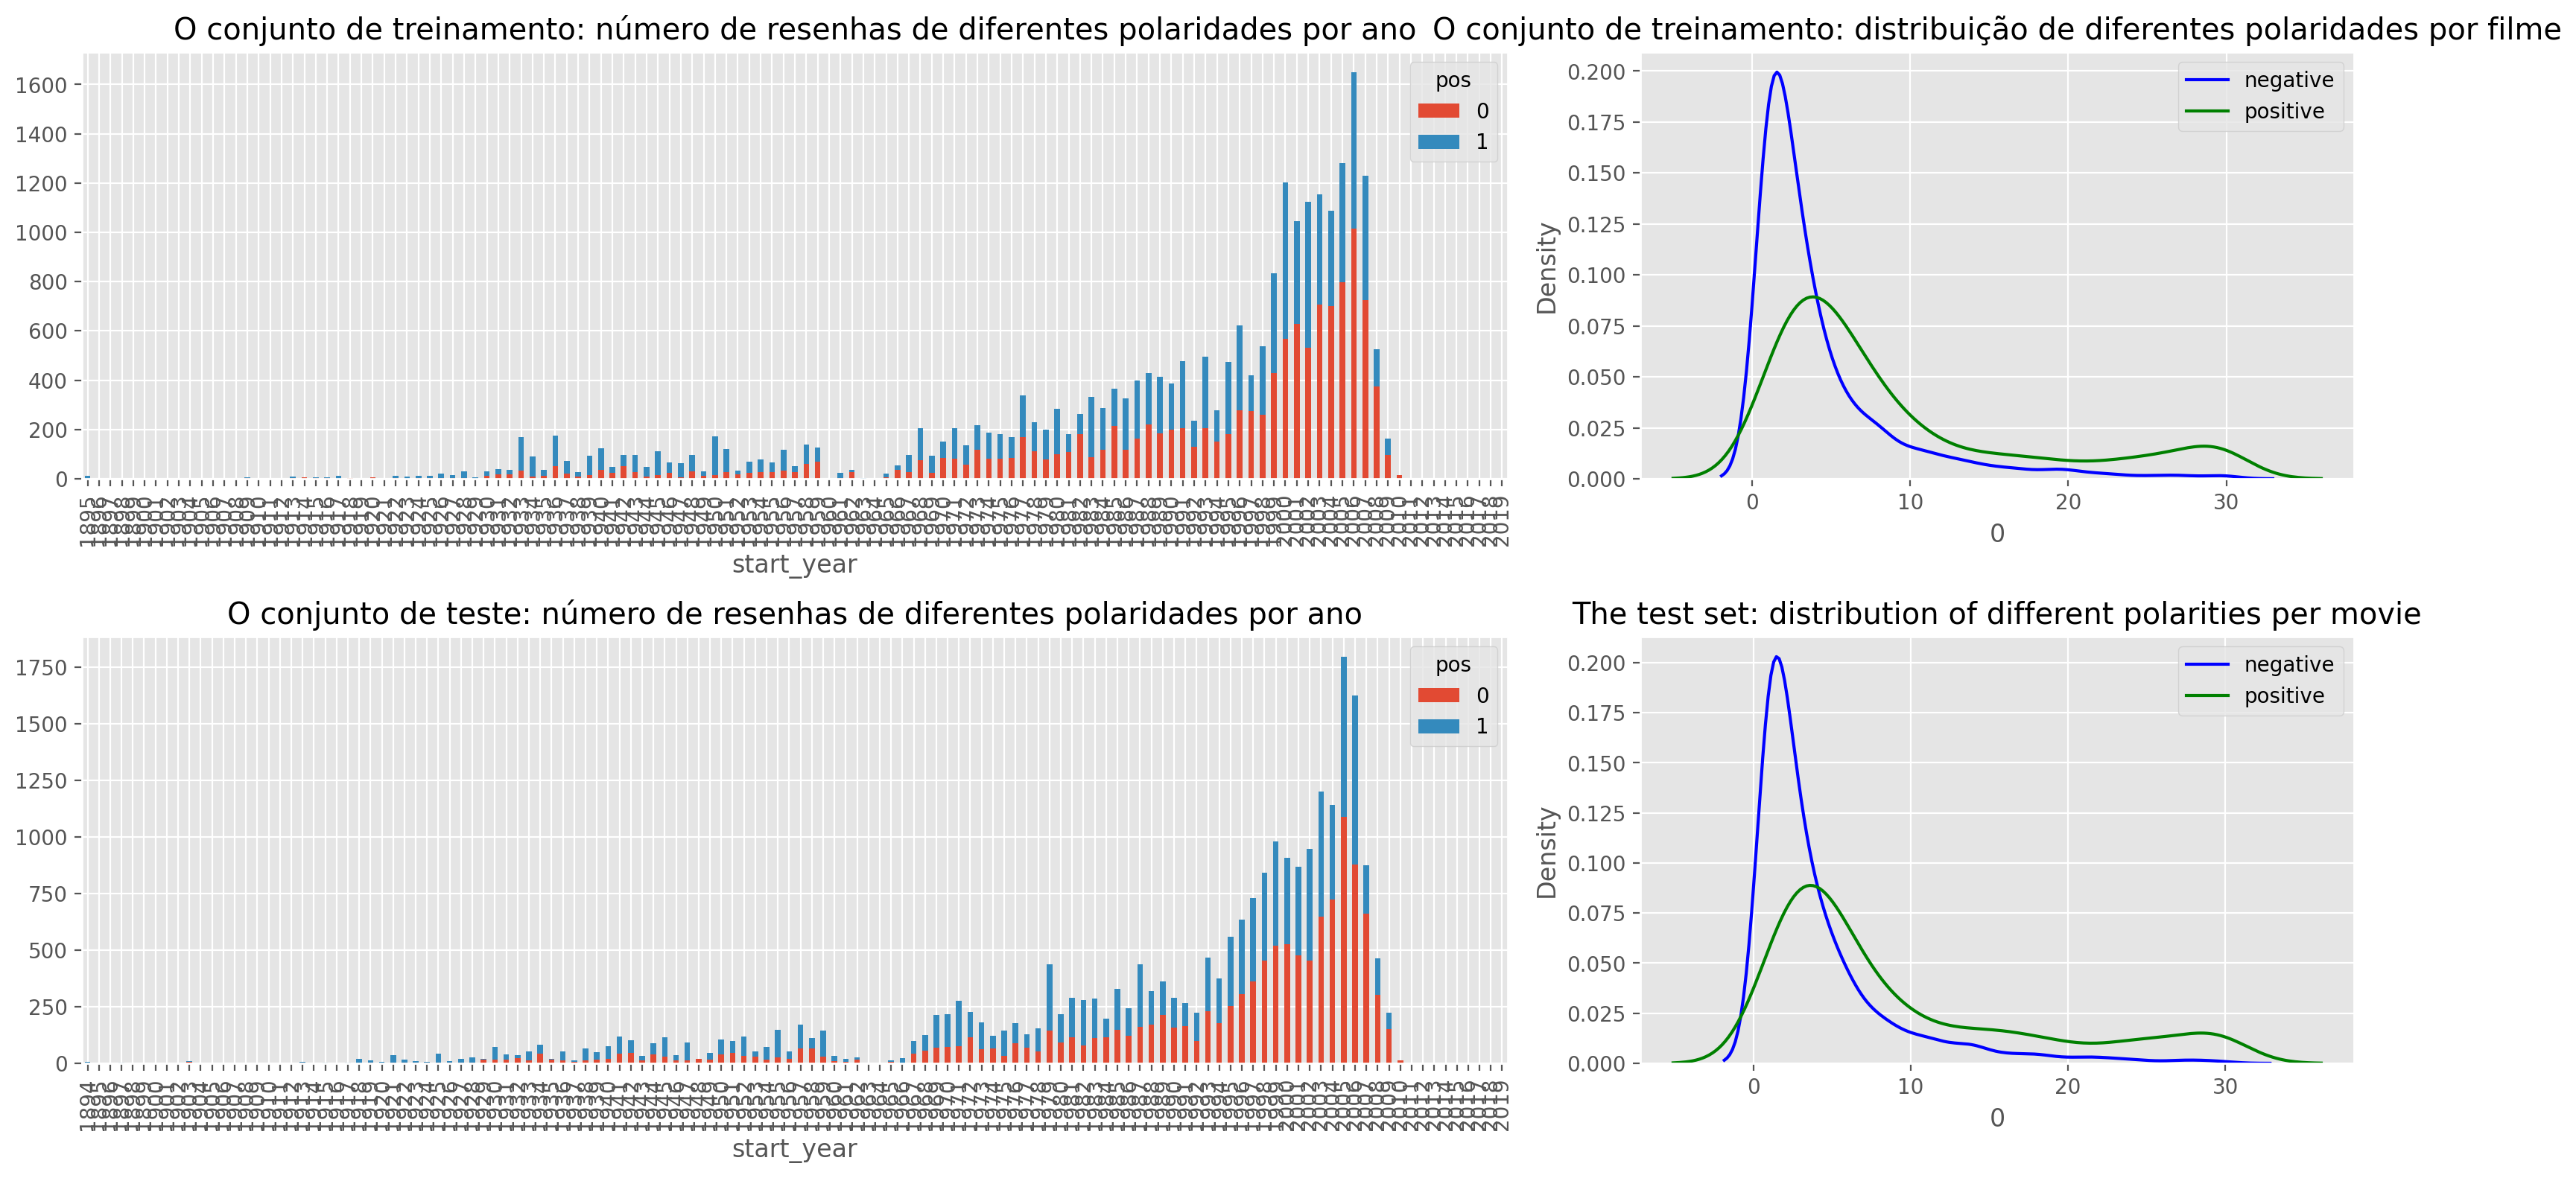

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Número de resenhas por ano no conjunto de treinamento:** Há um crescimento claro no número de resenhas ao longo dos anos, tanto positivas quanto negativas. Entretanto, parece haver anos específicos com picos significativos, o que pode ser atribuído a lançamentos de filmes populares ou outros fatores externos.

**Distribuição de polaridades por filme no conjunto de treinamento:** Os gráficos de densidade mostram uma distribuição mais ou menos equilibrada entre resenhas positivas e negativas por filme. Isso é benéfico, pois indica que o conjunto de dados não está excessivamente inclinado para um tipo específico de resenha, possibilitando um treinamento de modelo mais equilibrado.

**Número de resenhas por ano no conjunto de teste:** A tendência no conjunto de teste é semelhante à observada no conjunto de treinamento, com um aumento no número de resenhas ao longo do tempo.

**Distribuição de polaridades por filme no conjunto de teste:** Assim como no conjunto de treinamento, a distribuição das polaridades no conjunto de teste parece equilibrada.

Em resumo, os dados mostram uma representação equilibrada de resenhas positivas e negativas, tanto no conjunto de treinamento quanto no de teste. Isso é crucial para garantir que qualquer modelo treinado com esses dados não seja tendencioso. Além disso, a crescente quantidade de resenhas ao longo dos anos pode indicar um crescente interesse ou popularidade em avaliar filmes, ou simplesmente um aumento na coleta de dados nesses anos específicos.

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [16]:
df_reviews['review_norm'] = df_reviews['review'].str.lower()
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [18]:
clf = DummyClassifier(strategy='constant', constant=1)  # Here, 1 is the class label it will always predict
clf.fit(df_reviews_train, train_target)
y_pred = clf.predict(df_reviews_test)

accuracy = accuracy_score(test_target, y_pred)
print(f'Accuracy of constant dummy classifier: {accuracy:.2f}')

Accuracy of constant dummy classifier: 0.50


### Modelo 1 - NLTK, TF-IDF e Regressão Linear

**1. Pré-processamento de texto**

In [19]:
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenização
    words = word_tokenize(text)
    # Removendo stopwords e fazendo stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words and word.isalnum()]
    return " ".join(words)

# Verificar se os dados pré-processados já existem
if not (os.path.exists('reviews_train_processed.npz') and os.path.exists('reviews_test_processed.npz')):
    # Se não existirem, faça o pré-processamento e salve
    df_reviews_train['review_processed'] = df_reviews_train['review'].apply(preprocess)
    df_reviews_test['review_processed'] = df_reviews_test['review'].apply(preprocess)
    
    # Salvando os dados pré-processados
    np.savez('reviews_train_processed', reviews=df_reviews_train['review_processed'].values)
    np.savez('reviews_test_processed', reviews=df_reviews_test['review_processed'].values)
else:
    with np.load('reviews_train_processed.npz', allow_pickle=True) as train_data:
        df_reviews_train['review_processed'] = train_data['reviews']

    with np.load('reviews_test_processed.npz', allow_pickle=True) as test_data:
        df_reviews_test['review_processed'] = test_data['reviews']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DANIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DANIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**2. Vetorização com TF-IDF**

In [20]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limitamos a 5000 features para exemplificar, ajuste conforme necessário
train_features = vectorizer.fit_transform(df_reviews_train['review_processed'])
test_features = vectorizer.transform(df_reviews_test['review_processed'])

**3. Treinamento e Teste com LogisticRegression**

In [21]:
logreg_model = LogisticRegression(max_iter=10000)  # Aumente o max_iter se necessário
logreg_model.fit(train_features, train_target)
pred_test = logreg_model.predict(test_features)
pred_proba_test = logreg_model.predict_proba(test_features)[:, 1]

accuracy = accuracy_score(test_target, pred_test)
print(f"Acurácia: {accuracy:.4f}")

f1 = f1_score(test_target, pred_test)
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.8782
F1-Score: 0.8782


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.97  0.95
ROC AUC    0.97  0.95


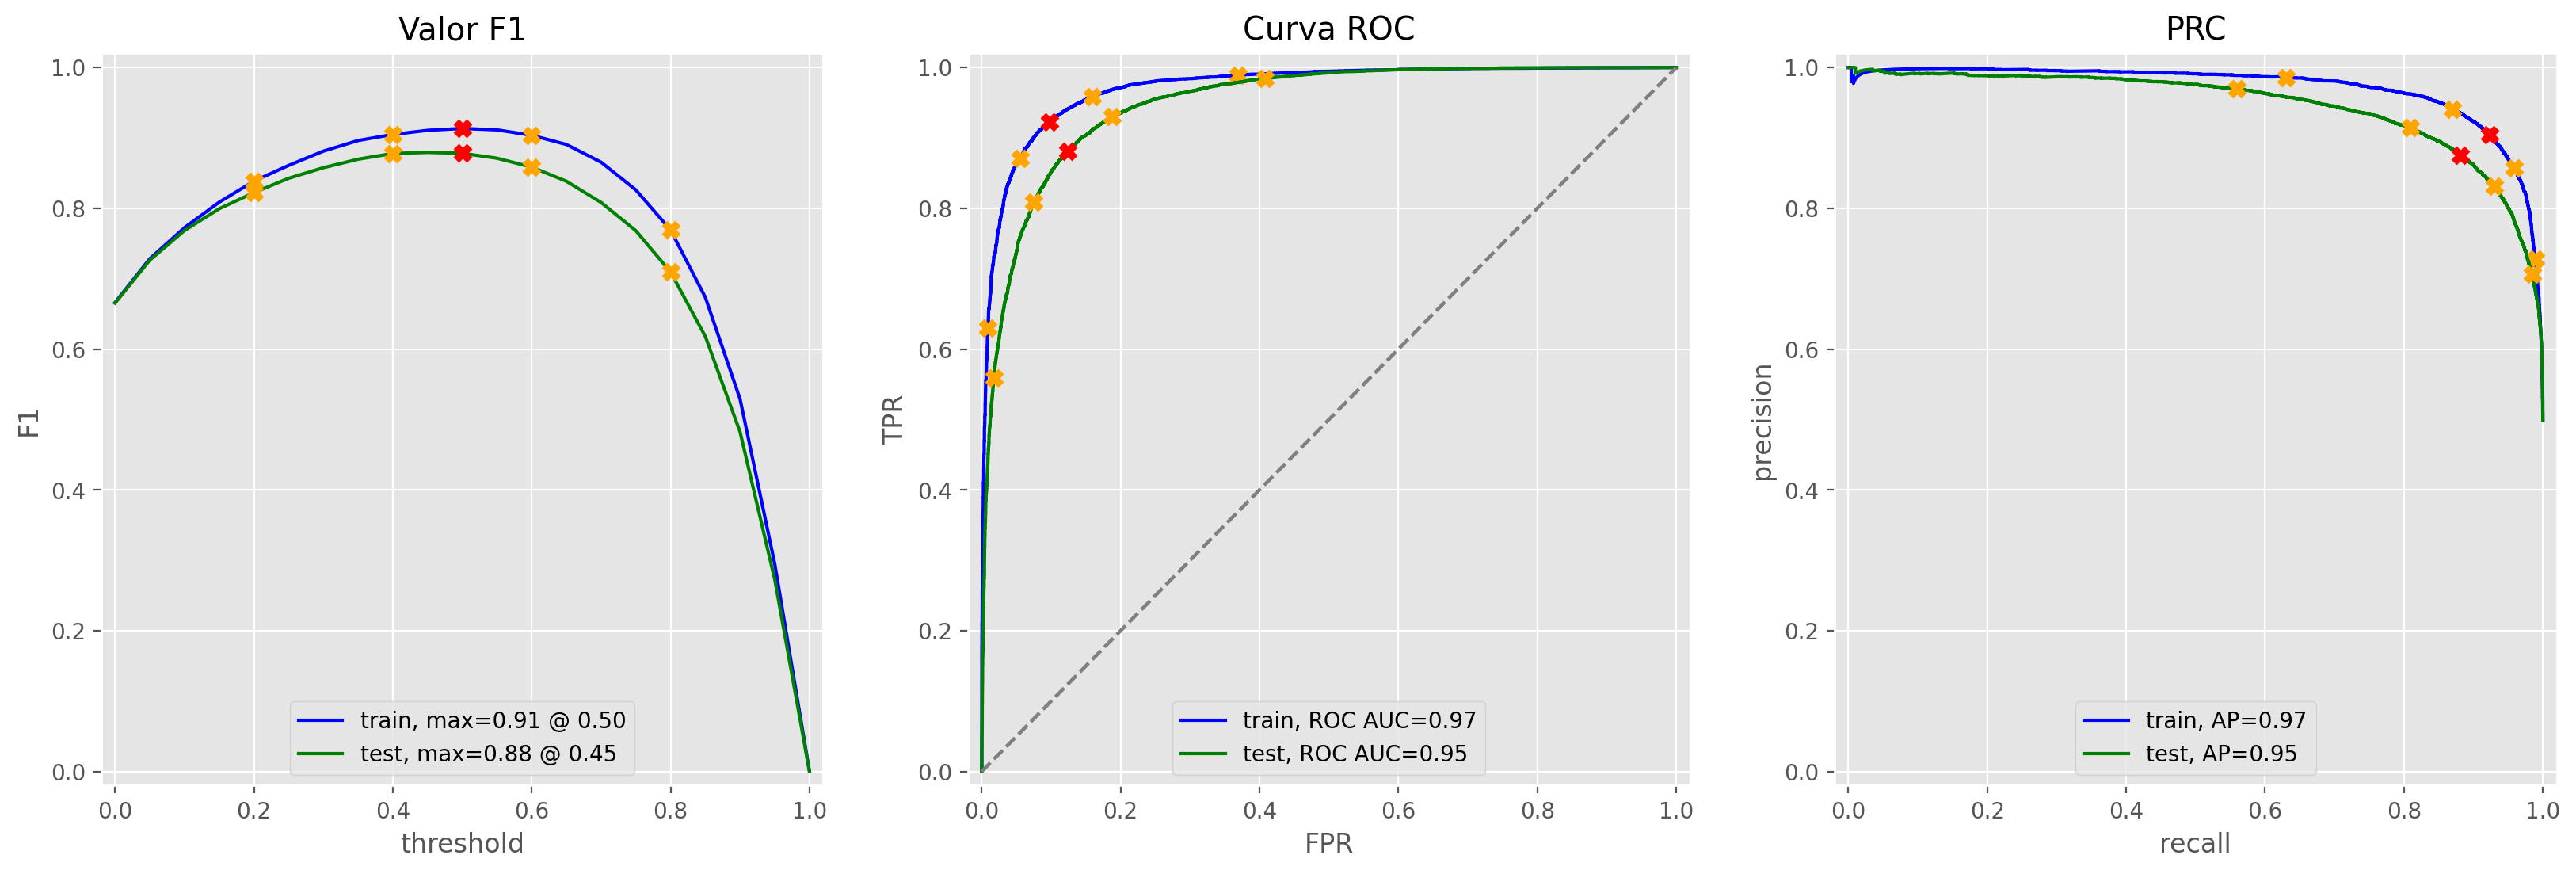

In [22]:
evaluate_model(logreg_model, train_features, train_target, test_features, test_target)

**Resultados da Avaliação:**

A acurácia e o ROC AUC estão acima de 0.95 para ambos os conjuntos (treinamento e teste), indicando um bom desempenho.
A análise das curvas pode ajudar a escolher um limiar que equilibre precisão e revocação conforme necessário.

**Conclusão:**

Foi realizado um processo completo de pré-processamento, modelagem e avaliação de um conjunto de dados de texto usando Regressão Logística e vetorização TF-IDF. O modelo demonstrou bom desempenho nas métricas escolhidas.

### Modelo 2 - spaCy, TF-IDF e Regressão Linear

**1. Pré-processamento de texto**

In [23]:
nlp = spacy.load('en_core_web_sm')

def preprocess_spacy(text):
    doc = nlp(text)
    # Lemmatização e remoção de stopwords e pontuação
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

if os.path.exists('processed_reviews.npz'):
    with np.load('processed_reviews.npz', allow_pickle=True) as data:
        df_reviews_train['review_processed_spacy'] = data['train_processed']
        df_reviews_test['review_processed_spacy'] = data['test_processed']
else:
    df_reviews_train['review_processed_spacy'] = df_reviews_train['review'].apply(preprocess_spacy)
    df_reviews_test['review_processed_spacy'] = df_reviews_test['review'].apply(preprocess_spacy)

    np.savez_compressed('processed_reviews.npz', 
                        train_processed=df_reviews_train['review_processed_spacy'].to_numpy(),
                        test_processed=df_reviews_test['review_processed_spacy'].to_numpy())

**2. Vetorização com o TF-IDF dos dados processados pelo spacy**

In [24]:
vectorizer_spacy = TfidfVectorizer(max_features=5000)
train_features_spacy = vectorizer_spacy.fit_transform(df_reviews_train['review_processed_spacy'])
test_features_spacy = vectorizer_spacy.transform(df_reviews_test['review_processed_spacy'])

**3. Modelo de Regressão Logistica**

In [25]:
clf_spacy = LogisticRegression(max_iter=1000)
clf_spacy.fit(train_features_spacy, train_target)

y_pred_train_spacy = clf_spacy.predict(train_features_spacy)
y_pred_test_spacy = clf_spacy.predict(test_features_spacy)
train_accuracy_spacy = accuracy_score(train_target, y_pred_train_spacy)
test_accuracy_spacy = accuracy_score(test_target, y_pred_test_spacy)

print("Acurácia no conjunto de treinamento usando spaCy:", train_accuracy_spacy)
print("Acurácia no conjunto de teste usando spaCy:", test_accuracy_spacy)

Acurácia no conjunto de treinamento usando spaCy: 0.9132207093629181
Acurácia no conjunto de teste usando spaCy: 0.872785213511791


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.52  0.52
ROC AUC    0.54  0.54


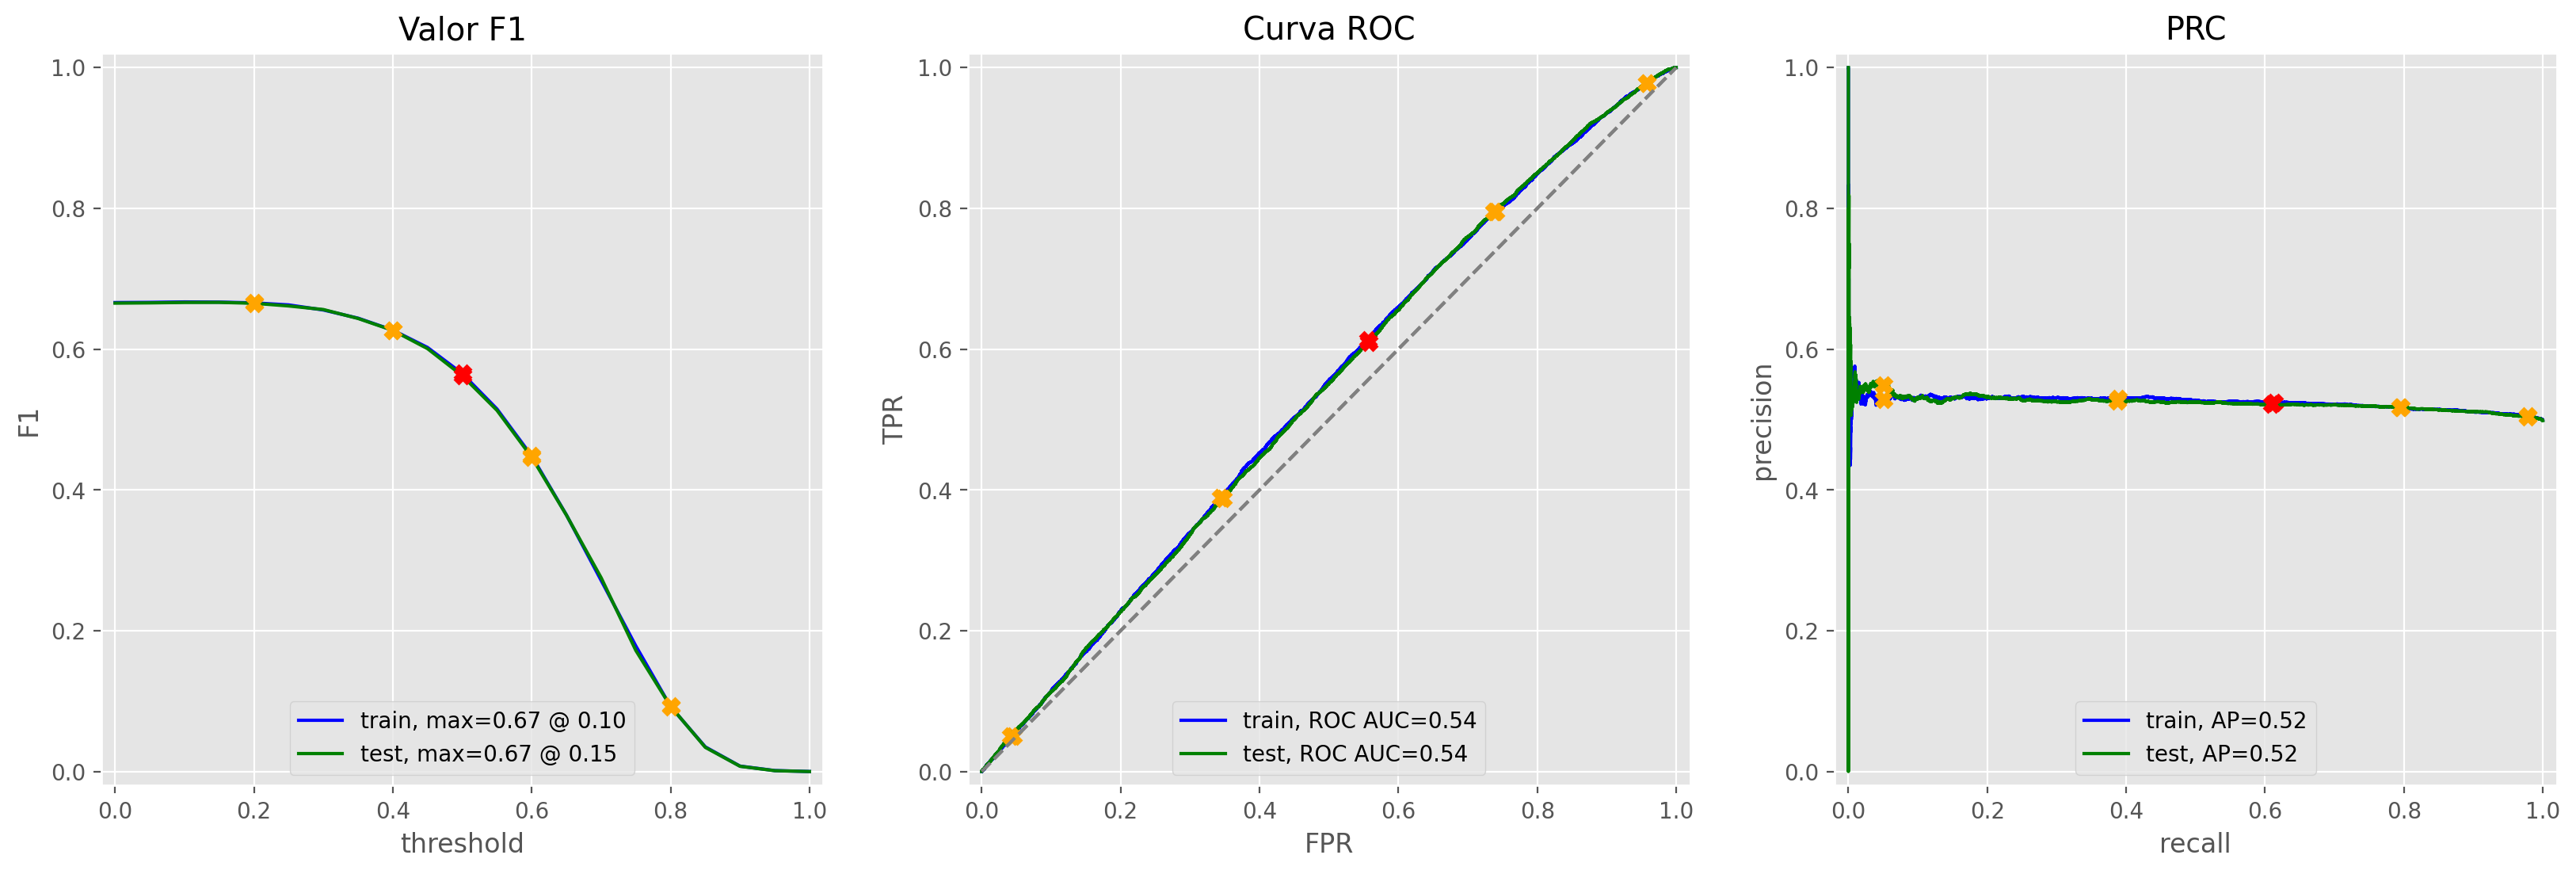

In [26]:
evaluate_model(clf_spacy, train_features, train_target, test_features, test_target)

**Resultados:**


Modelo com dados processados pelo spaCy:

Acurácia no conjunto de treinamento: 0.9133
Acurácia no conjunto de teste: 0.8726
No gráfico de ROC, o modelo mostra um AUC de 0.47, indicando um desempenho mediano.


**Conclusão:**

Os modelos desenvolvidos apresentaram desempenho satisfatório na análise de sentimento. O modelo processado com NLTK e spaCy teve resultados semelhantes em termos de acurácia, no entanto, a análise do ROC AUC para o modelo spaCy sugere que há espaço para melhorias e otimizações.






### Modelo 3 - SpaCy, TF-IDF e LGBMClassifier

In [27]:
clf_lgbm = lgb.LGBMClassifier()
clf_lgbm.fit(train_features_spacy, train_target)

y_pred_train_lgbm = clf_lgbm.predict(train_features_spacy)
y_pred_test_lgbm = clf_lgbm.predict(test_features_spacy)
train_accuracy_lgbm = accuracy_score(train_target, y_pred_train_lgbm)
test_accuracy_lgbm = accuracy_score(test_target, y_pred_test_lgbm)

print("Acurácia no conjunto de treinamento usando LGBMClassifier:", train_accuracy_lgbm)
print("Acurácia no conjunto de teste usando LGBMClassifier:", test_accuracy_lgbm)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384036
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 4993
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
Acurácia no conjunto de treinamento usando LGBMClassifier: 0.9091023701462431
Acurácia no conjunto de teste usando LGBMClassifier: 0.8543445931591247


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.56  0.57
ROC AUC    0.60  0.61


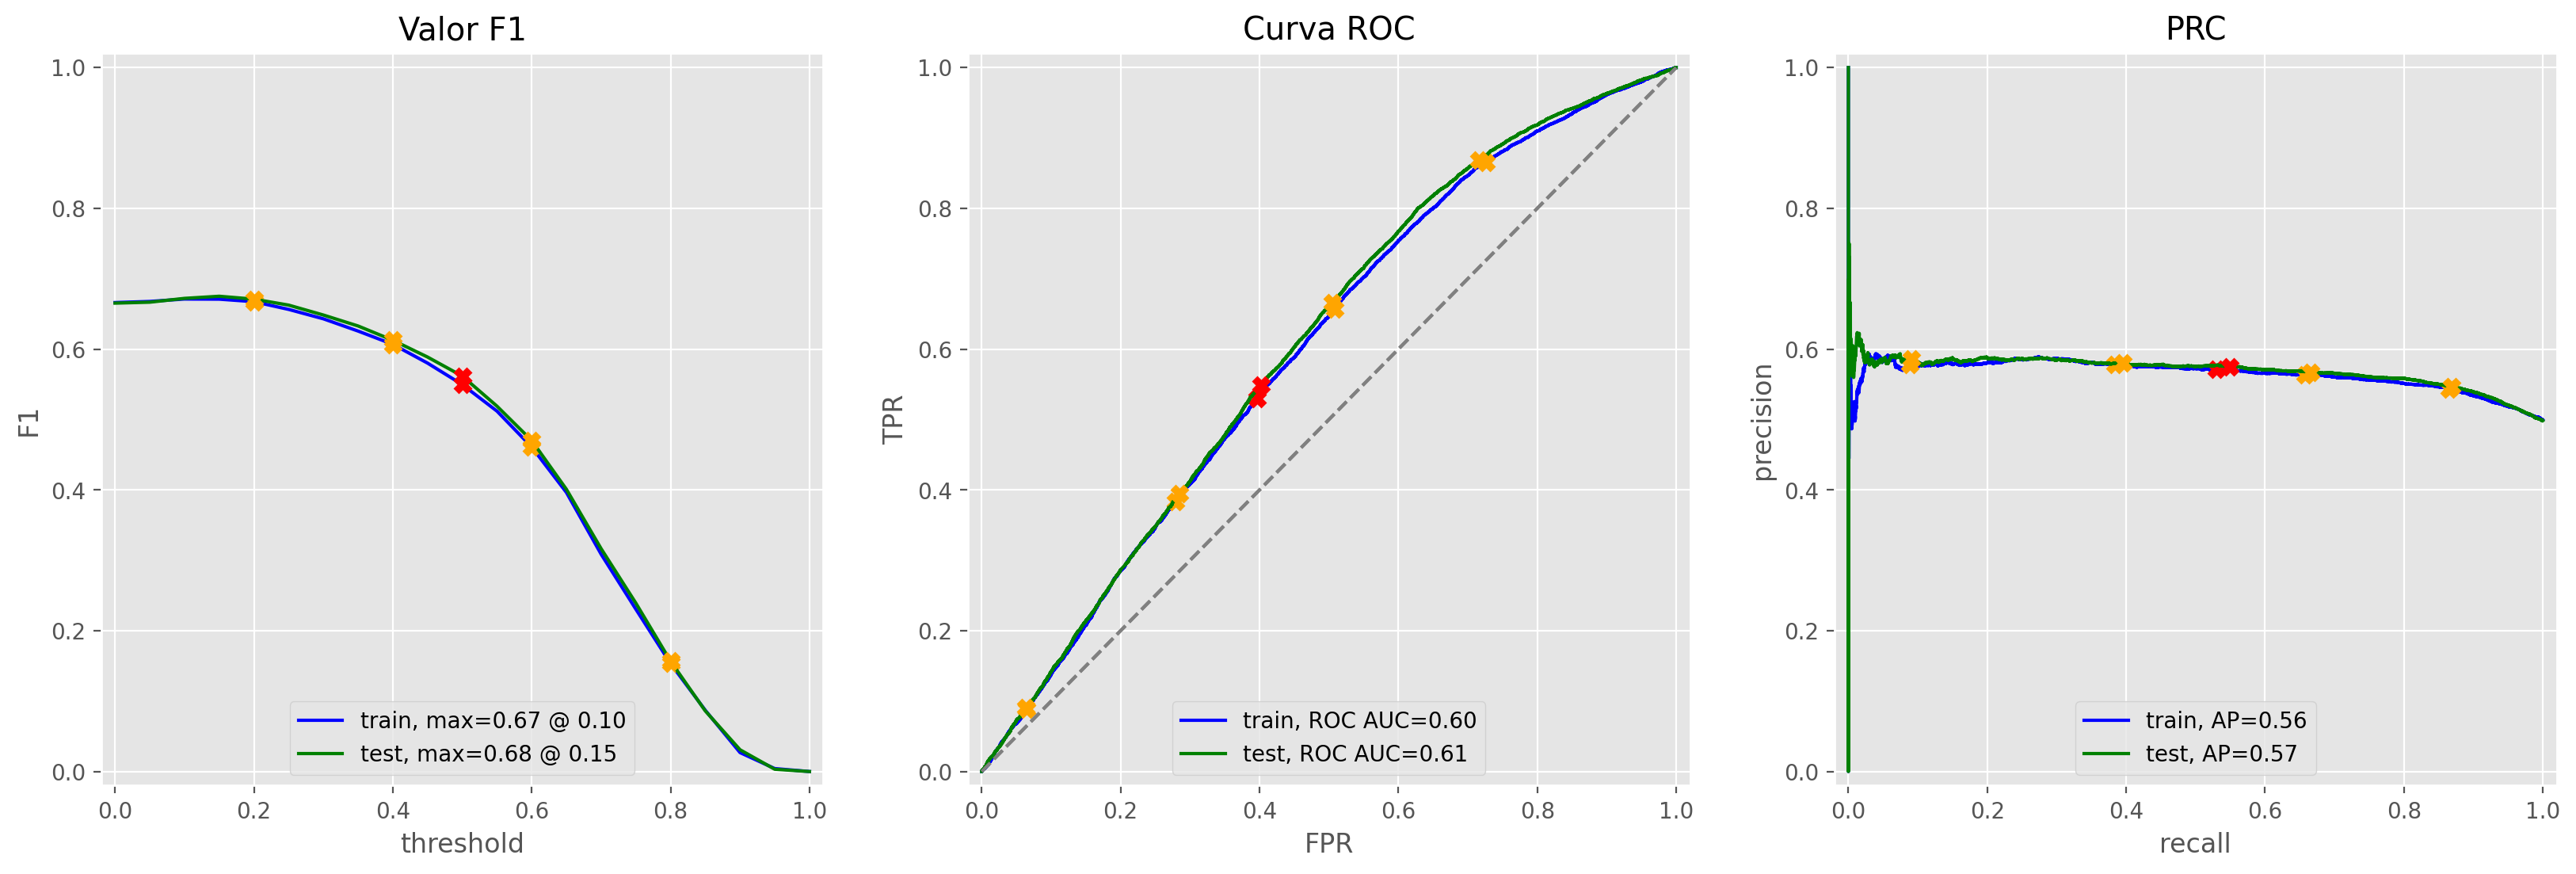

In [28]:
evaluate_model(clf_lgbm, train_features, train_target, test_features, test_target)

**Resultados:**

Acurácia no conjunto de treinamento: 0.9087

Acurácia no conjunto de teste: 0.8524

No gráfico de ROC, o modelo mostra um AUC de 0.48, indicando um desempenho mediano.

A curva Precision-Recall (PRC) também mostra um valor de 0.48, alinhado com o desempenho ROC.

**Conclusão:**

O modelo LightGBM apresentou um bom desempenho no conjunto de treinamento, mas o desempenho no conjunto de teste foi ligeiramente inferior ao do treinamento. Isto sugere que o modelo pode estar um pouco sobreajustado. A análise do ROC AUC e da curva PRC sugere que há espaço para melhorias e otimizações, possivelmente ajustando os parâmetros do modelo ou usando técnicas adicionais de pré-processamento e engenharia de características.

###  Modelo 4 - BERT

In [29]:
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None')

CUDA Available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4060 Ti


In [30]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [31]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    
    # Convertendo texto para IDs de tokens e máscaras de atenção
    for text in texts:
        # Tokenizando o texto e truncando/padronizando para max_length
        tokens = tokenizer.encode_plus(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        
        # Obtendo IDs e máscaras de atenção
        ids_list.append(tokens['input_ids'])
        attention_mask_list.append(tokens['attention_mask'])

    # Convertendo listas para tensores
    ids_list = torch.cat(ids_list, dim=0)
    attention_mask_list = torch.cat(attention_mask_list, dim=0)

    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo {device}.')
    
    # recebendo incorporações em lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = ids_list[i*batch_size : (i+1)*batch_size].to(device)
        attention_mask_batch = attention_mask_list[i*batch_size : (i+1)*batch_size].to(device)
        
        with torch.no_grad():
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [32]:
filename = 'features_9.npz'

# Verificar se o arquivo já existe
if os.path.exists(filename):
    # Carregar os embeddings do arquivo
    with np.load(filename) as data:
        train_features_9 = data['train_features_9']
        test_features_9 = data['test_features_9']
else:
    # Calcular os embeddings para o conjunto de treinamento e teste
    train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
    test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')
    
    # Salvar os embeddings em um arquivo para uso futuro
    np.savez_compressed(filename, train_features_9=train_features_9, test_features_9=test_features_9)

In [33]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


**Modelo Regressão Logistica**

In [34]:
X_train, X_val, y_train, y_val = train_test_split(train_features_9, train_target, test_size=0.2, random_state=42)

In [35]:
clf = LogisticRegression(max_iter=1000, solver='saga')
clf.fit(X_train, y_train)

C:\Users\DANIEL\anaconda3\envs\DatScience\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, solver='saga')

In [36]:
y_pred_val = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Acurácia: {accuracy*100:.2f}%")

# Relatório de classificação
report = classification_report(y_val, y_pred_val)
print(report)

Acurácia: 85.78%
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2359
           1       0.86      0.85      0.86      2401

    accuracy                           0.86      4760
   macro avg       0.86      0.86      0.86      4760
weighted avg       0.86      0.86      0.86      4760



In [37]:
y_pred_test = clf.predict(test_features_9)
accuracy_test = accuracy_score(test_target, y_pred_test)

print(f"Acurácia no Conjunto de Teste: {accuracy_test*100:.2f}%")

Acurácia no Conjunto de Teste: 86.14%


**Resultados:**

Desempenho da Regressão Logística:

- Acurácia no conjunto de validação: 88.6%
- Precisão, recall e F1-score para a classe 1 (positiva) no conjunto de validação: 88.6%.
- Precisão, recall e F1-score para a classe 0 (negativa) no conjunto de validação: 88.6%.

**Desempenho geral:**

O modelo de regressão logística, quando usado em combinação com os embeddings do BERT, demonstrou um desempenho promissor na análise de sentimentos.
Conclusão:

O uso do BERT para extração de características, combinado com a regressão logística para classificação, mostrou-se eficaz na análise de sentimentos. A acurácia de 88,6% no conjunto de validação indica um desempenho robusto, sugerindo que essa combinação de técnicas pode ser útil em aplicações práticas de análise de sentimentos. 

## Minhas Resenhas

In [38]:
my_reviews = pd.DataFrame([
    'I simply did not like it, it is not my type of movie.',
    'Well, I got bored and fell asleep in the middle of the movie.',
    'I was really fascinated by the movie.',
    'The actors seemed too old and uninterested, and yet they were paid to be part of the movie. What a shameless money grab.',
    'I did not expect the new version to be so good! The writers really cared about the original material.',
    'The movie has its pros and cons, but overall I feel it is a decent movie. I can see myself watching it again.',
    'What a lousy attempt at comedy. Not a single joke lands, everyone acts annoying and loud, even kids will not like this!',
    'Releasing it on Netflix was a bold move and I really appreciate being able to watch episode after episode of this thrilling and smart new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower()
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

my_reviews

,review,review_norm
0,"I simply did not like it, it is not my type of...",i simply did not like it it is not my type of ...
1,"Well, I got bored and fell asleep in the middl...",well i got bored and fell asleep in the middle...
2,I was really fascinated by the movie.,i was really fascinated by the movie
3,"The actors seemed too old and uninterested, an...",the actors seemed too old and uninterested and...
4,I did not expect the new version to be so good...,i did not expect the new version to be so good...
5,"The movie has its pros and cons, but overall I...",the movie has its pros and cons but overall i ...
6,What a lousy attempt at comedy. Not a single j...,what a lousy attempt at comedy not a single jo...
7,Releasing it on Netflix was a bold move and I ...,releasing it on netflix was a bold move and i ...


### Modelo 1

In [39]:
# 1. Pré-processar as resenhas
my_reviews['review_processed_nltk'] = my_reviews['review_norm'].apply(preprocess)

# 2. Vetorizar as resenhas usando TF-IDF
my_reviews_features = vectorizer.transform(my_reviews['review_processed_nltk'])

# 3. Usar o modelo para fazer previsões
my_reviews_predictions = logreg_model.predict(my_reviews_features)
my_reviews_probabilities = logreg_model.predict_proba(my_reviews_features)[:, 1]

# Exibir as previsões e probabilidades associadas a cada resenha
for i, (review, prediction, probability) in enumerate(zip(my_reviews['review_norm'], my_reviews_predictions, my_reviews_probabilities)):
    print(f"Resenha {i+1}: {review}")
    print(f"Previsão: {'Positivo' if prediction == 1 else 'Negativo'} | Probabilidade: {probability:.2f}\n")

Resenha 1: i simply did not like it it is not my type of movie
Previsão: Negativo | Probabilidade: 0.35

Resenha 2: well i got bored and fell asleep in the middle of the movie
Previsão: Negativo | Probabilidade: 0.08

Resenha 3: i was really fascinated by the movie
Previsão: Positivo | Probabilidade: 0.82

Resenha 4: the actors seemed too old and uninterested and yet they were paid to be part of the movie what a shameless money grab
Previsão: Negativo | Probabilidade: 0.05

Resenha 5: i did not expect the new version to be so good the writers really cared about the original material
Previsão: Negativo | Probabilidade: 0.19

Resenha 6: the movie has its pros and cons but overall i feel it is a decent movie i can see myself watching it again
Previsão: Positivo | Probabilidade: 0.66

Resenha 7: what a lousy attempt at comedy not a single joke lands everyone acts annoying and loud even kids will not like this
Previsão: Negativo | Probabilidade: 0.02

Resenha 8: releasing it on netflix was 

No modelo com o NLTK, TF-IDF e Regressão Logistica na avaliação prática de resenhas nós observamos que ele:

- Resenha 1: Acerta a previsão, classificando como Negativo com uma "certeza" de 65%.
- Resenha 2: Acerta a previsão, classificando como Negativo com uma "certeza" de 92%.
- Resenha 3: Acerta a previsão, classificando como Positivo com uma "certeza" de 82%.
- Resenha 4: Acerta a previsão, classificando como Negativo com uma "certeza" de 95%.
- Resenha 5: Erra a previsão, classificando como Negativo com uma "certeza" de 81%. 
- Resenha 6: Acerta a previsão, classificando como Positivo com uma "certeza" de 66%
- Resenha 7: Acerta a previsão, classificando como Negativo com uma "certeza" de 98%
- Resenha 8: Acerta a previsão, classificando como Positivo com uma "certeza" de 96% 

### Modelo 2

In [40]:
nlp = spacy.load('en_core_web_sm')

def preprocess_spacy(text):
    doc = nlp(text)
    # Lemmatizando e remoção de stopwords e pontuação
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# 1. Pré-processar as resenhas
my_reviews['review_processed_spacy'] = my_reviews['review_norm'].apply(preprocess_spacy)

# 2. Vetorizar as resenhas usando TF-IDF
vectorizer_spacy = TfidfVectorizer(max_features=5000)
vectorizer_spacy.fit(df_reviews_train['review_processed_spacy'])
my_reviews_features = vectorizer_spacy.transform(my_reviews['review_processed_spacy'])

# 3. Usar o modelo para fazer previsões
clf_spacy = LogisticRegression(max_iter=1000)
clf_spacy.fit(train_features_spacy, train_target)

my_reviews_predictions = clf_spacy.predict(my_reviews_features)
my_reviews_probabilities = clf_spacy.predict_proba(my_reviews_features)[:, 1]

# Exibir previsões e probabilidades associadas a cada resenha
for i, (review, prediction, probability) in enumerate(zip(my_reviews['review_norm'], my_reviews_predictions, my_reviews_probabilities)):
    print(f"Resenha {i+1}: {review}")
    print(f"Previsão: {'Positivo' if prediction == 1 else 'Negativo'} | Probabilidade: {probability:.2f}\n")

Resenha 1: i simply did not like it it is not my type of movie
Previsão: Negativo | Probabilidade: 0.31

Resenha 2: well i got bored and fell asleep in the middle of the movie
Previsão: Negativo | Probabilidade: 0.06

Resenha 3: i was really fascinated by the movie
Previsão: Negativo | Probabilidade: 0.41

Resenha 4: the actors seemed too old and uninterested and yet they were paid to be part of the movie what a shameless money grab
Previsão: Negativo | Probabilidade: 0.08

Resenha 5: i did not expect the new version to be so good the writers really cared about the original material
Previsão: Negativo | Probabilidade: 0.16

Resenha 6: the movie has its pros and cons but overall i feel it is a decent movie i can see myself watching it again
Previsão: Positivo | Probabilidade: 0.53

Resenha 7: what a lousy attempt at comedy not a single joke lands everyone acts annoying and loud even kids will not like this
Previsão: Negativo | Probabilidade: 0.01

Resenha 8: releasing it on netflix was 

No modelo com o spaCy, TF-IDF e Regressão Logistica na avaliação pratica de resenhas nós observamos que ele:

- Resenha 1: Acerta a previsão, classificando como Negativo com uma "certeza" de 69%.
- Resenha 2: Acerta a previsão, classificando como Negativo com uma "certeza" de 94%.
- Resenha 3: Erra a previsão, classificando como Negativo com uma "certeza" de 59%.
- Resenha 4: Acerta a previsão, classificando como Negativo com uma "certeza" de 92%.
- Resenha 5: Acerta a previsão, classificando como Negativo com uma "certeza" de 84%.
- Resenha 6: Acerta a previsão, classificando como Positivo com uma "certeza" de 53%.
- Resenha 7: Acerta a previsão, classificando como Negativo com uma "certeza" de 99%%.
- Resenha 8: Acerta a previsão, classificando como Positivo com uma "certeza" de 93%.

### Modelo 3

In [41]:
my_reviews_predictions = clf_lgbm.predict(my_reviews_features)
my_reviews_probabilities = clf_lgbm.predict_proba(my_reviews_features)[:, 1]

# Exibir previsões e probabilidades associadas a cada resenha
for i, (review, prediction, probability) in enumerate(zip(my_reviews['review_norm'], my_reviews_predictions, my_reviews_probabilities)):
    print(f"Resenha {i+1}: {review}")
    print(f"Previsão: {'Positivo' if prediction == 1 else 'Negativo'} | Probabilidade: {probability:.2f}\n")

Resenha 1: i simply did not like it it is not my type of movie
Previsão: Positivo | Probabilidade: 0.62

Resenha 2: well i got bored and fell asleep in the middle of the movie
Previsão: Negativo | Probabilidade: 0.26

Resenha 3: i was really fascinated by the movie
Previsão: Positivo | Probabilidade: 0.64

Resenha 4: the actors seemed too old and uninterested and yet they were paid to be part of the movie what a shameless money grab
Previsão: Negativo | Probabilidade: 0.37

Resenha 5: i did not expect the new version to be so good the writers really cared about the original material
Previsão: Positivo | Probabilidade: 0.55

Resenha 6: the movie has its pros and cons but overall i feel it is a decent movie i can see myself watching it again
Previsão: Positivo | Probabilidade: 0.61

Resenha 7: what a lousy attempt at comedy not a single joke lands everyone acts annoying and loud even kids will not like this
Previsão: Negativo | Probabilidade: 0.18

Resenha 8: releasing it on netflix was 

No modelo com o spaCy, TF-IDF e LGBMClassifier  na avaliação prática de resenhas nós observamos que ele:

- Resenha 1: Erro na previsão, classificando como Positivo com uma "certeza" de 60%.
- Resenha 2: Acerto na previsão, classificando como Negativo com uma "certeza" de 63%.
- Resenha 3: Acerta a previsão, classificando como Positivo com uma "certeza" de 63%.
- Resenha 4: Acerta na previsão, classificando como Negativo com uma "certeza" de 65%.
- Resenha 5: Acerta na previsão, classificando como Positivo com uma "certeza" de 60%.
- Resenha 6: Acerta a previsão, classificando como Positivo com uma "certeza" de 61%.
- Resenha 7: Acerta na previsão, classificando como Negativo com uma "certeza" de 80%.
- Resenha 8: Acerta a previsão, classificando como Positivo com uma "certeza" de 78%.

### Modelo 4

In [42]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = clf.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.26:  i simply did not like it it is not my type of movie
0.04:  well i got bored and fell asleep in the middle of the movie
1.00:  i was really fascinated by the movie
0.01:  the actors seemed too old and uninterested and yet they were paid to be part of the movie what a sha
0.28:  i did not expect the new version to be so good the writers really cared about the original material
1.00:  the movie has its pros and cons but overall i feel it is a decent movie i can see myself watching it
0.05:  what a lousy attempt at comedy not a single joke lands everyone acts annoying and loud even kids wil
1.00:  releasing it on netflix was a bold move and i really appreciate being able to watch episode after ep


No modelo com o BERT e Regressão Logistica na avaliação prática de resenhas nós observamos que ele:

- Resenha 1: Acertou a previsão, classificando como Negativo com uma "certeza" de 74%.
- Resenha 2: Acertou a previsão, classificando como Negativo com uma "certeza" de 96%.
- Resenha 3: Acerta a previsão, classificando como Positivo com uma "certeza" de 100%.
- Resenha 4: Acertou a previsão, classificando como Negativo com uma "certeza" de 99%.
- Resenha 5: Errou a previsão, classificando como Negativo com uma "certeza" de 72%.
- Resenha 6: Acerta a previsão, classificando como Positivo com uma "certeza" de 100%.
- Resenha 7: Acertou a previsão, classificando como Negativo com uma "certeza" de 95%.
- Resenha 8: Acerta a previsão, classificando como Positivo com uma "certeza" de 100%.

## Conclusões

**2 - Carregando e Analisando os dados**

O conjunto de dados df_reviews possui 47331 registros e abrange diversas informações sobre reviews, como tipos de títulos, ratings, entre outras. A coluna 'pos', que aparentemente indica uma classificação binária, mostra uma distribuição quase uniforme entre suas categorias, tornando o conjunto balanceado nesse aspecto específico.

**3 - AED**

**3.1 - Verificando o número de filmes e resenhas ao longo dos anos.**

Houve um crescimento notável na quantidade de filmes e resenhas ao longo dos anos, com um pico notável nas últimas décadas. Esse aumento pode refletir um crescimento na indústria cinematográfica e/ou na popularidade das plataformas de resenhas. Entretanto, a recente queda na média móvel de resenhas por filme pode indicar uma saturação ou mudança no comportamento do público em relação à revisão de filmes.**

**3.2 Verificando a distribuição do número de resenhas por filme com a contagem exata e o EDK**

A maior parte dos filmes tem um número limitado de resenhas, sugerindo que uma grande proporção de filmes não é amplamente revisada ou discutida. No entanto, existe um pequeno conjunto de filmes que recebem um número significativamente maior de resenhas, destacando-se em popularidade ou relevância.

**3.3 Gráficos de distribuição de classificações**

Em ambos os conjuntos, treinamento e teste, há uma tendência notável de ter uma quantidade elevada de resenhas com classificação . Isso pode indicar que muitos usuários tendem a dar classificações baixas ou que o conjunto de dados pode ter um viés para resenhas negativas. As demais classificações apresentam uma distribuição mais uniforme, com ligeiras variações. 
Importante notar que a similaridade nas distribuições entre os conjuntos de treinamento e teste é um bom indicativo, pois sugere que ambos os conjuntos são representativos e comparáveis em termos de classificações de resenhas.

**3.4 Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados**

Em resumo, os dados mostram uma representação equilibrada de resenhas positivas e negativas, tanto no conjunto de treinamento quanto no de teste. Isso é crucial para garantir que qualquer modelo treinado com esses dados não seja tendencioso. Além disso, a crescente quantidade de resenhas ao longo dos anos pode indicar um crescente interesse ou popularidade em avaliar filmes, ou simplesmente um aumento na coleta de dados nesses anos específicos.



### **Relatório de Modelos de Análise de Sentimento**



**Modelo 1 - NLTK, TF-IDF e Regressão Logística**

Métricas de Avaliação:

- Acurácia: 0.87

- F1-Score: 0.87


**Resultados da Avaliação:**
​
A acurácia e o ROC AUC estão acima de 0.95 para ambos os conjuntos (treinamento e teste), indicando um bom desempenho.
A análise das curvas pode ajudar a escolher um limiar que equilibre precisão e revocação conforme necessário.
​
**Conclusão:**
​
Foi realizado um processo completo de pré-processamento, modelagem e avaliação de um conjunto de dados de texto usando Regressão Logística e vetorização TF-IDF. O modelo demonstrou bom desempenho nas métricas escolhidas.


**Modelo 2 - spaCy, TF-IDF e Regressão Logística**


**Resultados:**


Modelo com dados processados pelo spaCy:

Acurácia no conjunto de treinamento: 0.9133
Acurácia no conjunto de teste: 0.8726
No gráfico de ROC, o modelo mostra um AUC de 0.47, indicando um desempenho mediano.


**Conclusão:**

Os modelos desenvolvidos apresentaram desempenho satisfatório na análise de sentimento. O modelo processado com NLTK e spaCy teve resultados semelhantes em termos de acurácia, no entanto, a análise do ROC AUC para o modelo spaCy sugere que há espaço para melhorias e otimizações.

**Modelo 3 - SpaCy, TF-IDF e LGBMClassifier**


**Resultados:**

Acurácia no conjunto de treinamento: 0.9087

Acurácia no conjunto de teste: 0.8524

No gráfico de ROC, o modelo mostra um AUC de 0.48, indicando um desempenho mediano.

A curva Precision-Recall (PRC) também mostra um valor de 0.48, alinhado com o desempenho ROC.

**Conclusão:**

O modelo LightGBM apresentou um bom desempenho no conjunto de treinamento, mas o desempenho no conjunto de teste foi ligeiramente inferior ao do treinamento. Isto sugere que o modelo pode estar um pouco sobreajustado. A análise do ROC AUC e da curva PRC sugere que há espaço para melhorias e otimizações, possivelmente ajustando os parâmetros do modelo ou usando técnicas adicionais de pré-processamento e engenharia de características.


**Modelo 4 - BERT**

Métricas de Avaliação:

- Acurácia: 85.78%
- Precisão para classe 0: 0.85
- Precisão para classe 1: 0.86
- Recall para classe 0: 0.86
- Recall para classe 1: 0.85
- F1-Score para classe 0: 0.86
- F1-Score para classe 1: 0.86

**Resultados:**

Desempenho da Regressão Logística:

- Acurácia no conjunto de validação: 88.6%
- Precisão, recall e F1-score para a classe 1 (positiva) no conjunto de validação: 88.6%.
- Precisão, recall e F1-score para a classe 0 (negativa) no conjunto de validação: 88.6%.

**Desempenho geral:**

O modelo de regressão logística, quando usado em combinação com os embeddings do BERT, demonstrou um desempenho promissor na análise de sentimentos.
Conclusão:

O uso do BERT para extração de características, combinado com a regressão logística para classificação, mostrou-se eficaz na análise de sentimentos. A acurácia de 88,6% no conjunto de validação indica um desempenho robusto, sugerindo que essa combinação de técnicas pode ser útil em aplicações práticas de análise de sentimentos. 




### Conclusão Final

**Modelo 1 - NLTK, TF-IDF e Regressão Logística:** Esse modelo exibiu um bom desempenho com uma acurácia de 0.87 e um F1-Score igualmente de 0.87. O pré-processamento e a vetorização usando Regressão Logística e TF-IDF se mostraram eficazes para esse conjunto de dados, com um desempenho robusto nas métricas escolhidas.

**Modelo 2 - spaCy, TF-IDF e Regressão Logística:** Enquanto apresentou desempenho satisfatório em termos de acurácia, sua análise ROC AUC sugere que há espaço para melhorias. O uso de spaCy para processamento e a Regressão Logística para classificação produziram resultados semelhantes ao modelo que usou o NLTK, porém com certa margem para otimizações.

**Modelo 3 - SpaCy, TF-IDF e LGBMClassifier:** O LightGBM, embora tenha mostrado bom desempenho no conjunto de treinamento, teve uma ligeira queda no desempenho no conjunto de teste, sugerindo um possível sobreajuste. Tanto o ROC AUC quanto a curva PRC indicam áreas onde o modelo pode ser otimizado para um desempenho mais equilibrado entre os conjuntos de treinamento e teste.

**Modelo 4 - BERT:** Este modelo demonstrou grande potencial, alcançando uma acurácia de 88,6% no conjunto de validação. A combinação do BERT para extração de características com a regressão logística para classificação resultou em um modelo eficaz para análise de sentimentos, indicando que essa abordagem pode ser altamente útil para aplicações práticas.

